# Clustering: Leiden 

In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

In [2]:
import glob
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET

### Load Samples & FlowJo 10 workspace

In [3]:
# 1) your inputs
wsp_path    = "/home/jiawu2/FlowKit_Cytometry/BrownLab_UPN811/BrownLab_UPN811_Tcell2_panel_CSF.wsp"
sample_path  = "/home/jiawu2/FlowKit_Cytometry/BrownLab_UPN811/fcs_files"


In [4]:
# 1) parse SampleNode names out of the WSP (just to confirm what names FlowKit expects)
tree = ET.parse(wsp_path)
root = tree.getroot()
wsp_names = [node.attrib['name'] for node in root.findall('.//SampleNode')]
print("WSP expects these sample names:", wsp_names)

WSP expects these sample names: ['C3D1_CSF_Tcell2_C1.0001.fcs', 'C1D0_CSF_Tcell2_C1.0001.fcs', 'C1D1_CSF_Tcell2_C3.0001.fcs', 'C2D0_CSF_Tcell2_C3.0001.fcs', 'C2D1_CSF_Tcell2_C3.0001.fcs', 'C3D0_CSF_Tcell2_C3.0001.fcs']


In [5]:
# 1) parse SampleNode names out of the WSP (just to confirm what names FlowKit expects)
tree = ET.parse(wsp_path)
root = tree.getroot()
wsp_names = [node.attrib['name'] for node in root.findall('.//SampleNode')]
print("WSP expects these sample names:", wsp_names)

WSP expects these sample names: ['C3D1_CSF_Tcell2_C1.0001.fcs', 'C1D0_CSF_Tcell2_C1.0001.fcs', 'C1D1_CSF_Tcell2_C3.0001.fcs', 'C2D0_CSF_Tcell2_C3.0001.fcs', 'C2D1_CSF_Tcell2_C3.0001.fcs', 'C3D0_CSF_Tcell2_C3.0001.fcs']


In [6]:
# 2) glob your .fcs files
fcs_files = glob.glob(os.path.join(sample_path, "*.fcs"))
print("Found on disk:", [os.path.basename(f) for f in fcs_files])

Found on disk: ['C1D0_CSF_Tcell2_C1.0001.fcs', 'C3D0_CSF_Tcell2_C3.0001.fcs', 'C1D1_CSF_Tcell2_C3.0001.fcs', 'C3D1_CSF_Tcell2_C1.0001.fcs', 'C2D1_CSF_Tcell2_C3.0001.fcs', 'C2D0_CSF_Tcell2_C3.0001.fcs']


In [7]:
# 3) build each Sample with the filename as its ID, and ignore the offset error
samples = []
for fcs in fcs_files:
    fname = os.path.basename(fcs)
    if fname not in wsp_names:
        raise ValueError(f"File {fname!r} not listed in WSP SampleNode names")
    samples.append(
        fk.Sample(
            fcs,
            sample_id=fname,            # instead of the numeric sampleID
            ignore_offset_error=True
        )
    )

In [8]:
# 4) create the Workspace
workspace = fk.Workspace(
    wsp_path,
    fcs_samples=samples,
    find_fcs_files_from_wsp=False
)

In [9]:
# — now you should actually load your files —
print("Loaded sample IDs:", workspace.get_sample_ids())

Loaded sample IDs: ['C1D0_CSF_Tcell2_C1.0001.fcs', 'C1D1_CSF_Tcell2_C3.0001.fcs', 'C2D0_CSF_Tcell2_C3.0001.fcs', 'C2D1_CSF_Tcell2_C3.0001.fcs', 'C3D0_CSF_Tcell2_C3.0001.fcs', 'C3D1_CSF_Tcell2_C1.0001.fcs']


In [10]:
sample_groups = workspace.get_sample_groups()
sample_groups

['All Samples']

In [11]:
# Pick the group you actually want to work with 
sample_group = 'All Samples'

In [12]:
sample_ids = workspace.get_sample_ids()
sample_ids

['C1D0_CSF_Tcell2_C1.0001.fcs',
 'C1D1_CSF_Tcell2_C3.0001.fcs',
 'C2D0_CSF_Tcell2_C3.0001.fcs',
 'C2D1_CSF_Tcell2_C3.0001.fcs',
 'C3D0_CSF_Tcell2_C3.0001.fcs',
 'C3D1_CSF_Tcell2_C1.0001.fcs']

In [13]:
sample_id = 'C3D1_CSF_Tcell2_C1.0001.fcs'

In [14]:
print(workspace.get_gate_hierarchy(sample_id, output='ascii'))

root
╰── Time Gate
    ╰── R1
        ╰── Live
            ╰── Single Cells
                ╰── Lymphocytes
                    ├── CD8
                    ╰── nonCD8


### Run analyze_samples & retrieve gated events as DataFrames

In [15]:
workspace.analyze_samples(sample_group)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [16]:
dfs = []
for sample_id in sample_ids:
    df = workspace.get_gate_events(sample_id, gate_name="Lymphocytes")
    dfs.append(df)

In [17]:
dfs[0].head()

,sample_id,HDR-T HDR-T,FSC-A FSC-A,FSC-H FSC-H,FSC-W FSC-W,SSC-A SSC-A,SSC-H SSC-H,SSC-W SSC-W,V1-A DAPI_VioBlue-A,V1-H DAPI_VioBlue-H,...,B3-W CXCR3_PerCP-Vio700-W,B4-A CD19_PE-Vio770-A,B4-H CD19_PE-Vio770-H,B4-W CD19_PE-Vio770-W,R1-A CD27_APC-A,R1-H CD27_APC-H,R1-W CD27_APC-W,R2-A CD8_APC-Vio770-A,R2-H CD8_APC-Vio770-H,R2-W CD8_APC-Vio770-W
646,C1D0_CSF_Tcell2_C1.0001.fcs,0.060409,0.455333,0.308310,0.738433,0.180690,0.165388,0.546263,0.602158,0.588514,...,0.957063,0.385269,0.415934,0.936018,0.000000,0.467253,0.903043,0.511324,0.431853,0.999612
654,C1D0_CSF_Tcell2_C1.0001.fcs,0.060959,0.470394,0.320883,0.732968,0.089588,0.086955,0.515140,0.476401,0.348619,...,0.970022,0.454939,0.459929,0.947954,0.557164,0.558231,0.950776,0.000000,0.000000,0.981229
662,C1D0_CSF_Tcell2_C1.0001.fcs,0.062073,0.386358,0.270543,0.714042,0.059100,0.057655,0.512534,0.000000,0.109388,...,0.975070,0.235378,0.417324,0.899563,0.635528,0.616976,0.964821,0.504468,0.470961,0.970143
665,C1D0_CSF_Tcell2_C1.0001.fcs,0.062434,0.389287,0.268640,0.724550,0.060156,0.058626,0.513045,0.388937,0.000000,...,0.871773,0.501036,0.473512,0.960268,0.571551,0.516179,0.980168,0.000000,0.415305,0.884911
667,C1D0_CSF_Tcell2_C1.0001.fcs,0.062713,0.381864,0.267167,0.714654,0.061704,0.057123,0.540095,0.456960,0.324663,...,0.961543,0.408615,0.452772,0.921214,0.570558,0.575561,0.944939,0.429703,0.421424,0.946382


In [18]:
# subsample 10_000  events and ignore sample_id & Time columns
k = 900     # donot use maximum cell number, could lead to NaN value
X = pd.concat([df.iloc[:, 1:-1].sample(k) for df in dfs])

In [19]:
X.head()

,HDR-T HDR-T,FSC-A FSC-A,FSC-H FSC-H,FSC-W FSC-W,SSC-A SSC-A,SSC-H SSC-H,SSC-W SSC-W,V1-A DAPI_VioBlue-A,V1-H DAPI_VioBlue-H,V1-W DAPI_VioBlue-W,...,B3-H CXCR3_PerCP-Vio700-H,B3-W CXCR3_PerCP-Vio700-W,B4-A CD19_PE-Vio770-A,B4-H CD19_PE-Vio770-H,B4-W CD19_PE-Vio770-W,R1-A CD27_APC-A,R1-H CD27_APC-H,R1-W CD27_APC-W,R2-A CD8_APC-Vio770-A,R2-H CD8_APC-Vio770-H
1590,0.144675,0.390805,0.276126,0.707657,0.061769,0.059148,0.522158,0.450409,0.394555,0.955571,...,0.465119,0.980193,0.401670,0.471788,0.920731,0.429248,0.480297,0.954989,0.511696,0.492135
998,0.093428,0.409018,0.283506,0.721358,0.051053,0.053986,0.472837,0.000000,0.379963,0.914380,...,0.443566,0.982926,0.404867,0.436164,0.937214,0.611949,0.605285,0.956514,0.000000,0.299846
6452,0.574026,0.538242,0.368717,0.729885,0.046249,0.045701,0.505997,0.492815,0.467017,0.959485,...,0.420191,0.976956,0.461637,0.458587,0.958041,0.544142,0.543636,0.958773,0.409764,0.480825
2378,0.213833,0.361983,0.255694,0.707843,0.049649,0.047308,0.524752,0.341641,0.376428,0.936082,...,0.303324,0.913563,0.408848,0.459694,0.895940,0.608078,0.566172,0.980658,0.506004,0.479398
4780,0.425430,0.463210,0.311037,0.744622,0.265826,0.223366,0.595047,0.628635,0.619149,0.951987,...,0.642276,0.965854,0.602674,0.581132,0.965913,0.000000,0.000000,0.974360,0.604899,0.567114


In [20]:
# Filter out Height channels (except those ending in '-H7') and any channel containing HDR, FSC, SSC, DAPI, BV650, FITC, or xxx
X_filtered = X.loc[:, ~(
    X.columns.str.endswith(('-H', '-W')) |
    X.columns.str.contains('HDR|FSC|SSC|DAPI|PD1|CD47')
)]

In [21]:
X_filtered.head() 

,V2-A CD3_VioGreen-A,B2-A CD28_PE-A,B3-A CXCR3_PerCP-Vio700-A,B4-A CD19_PE-Vio770-A,R1-A CD27_APC-A,R2-A CD8_APC-Vio770-A
1590,0.723910,0.658028,0.537199,0.401670,0.429248,0.511696
998,0.675803,0.580371,0.508745,0.404867,0.611949,0.000000
6452,0.710731,0.678746,0.506030,0.461637,0.544142,0.409764
2378,0.679555,0.593261,0.000000,0.408848,0.608078,0.506004
4780,0.712809,0.666408,0.660083,0.602674,0.000000,0.604899


### Perform Louvain & Leiden clustering

In [22]:
# Scale the data (a kind of z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

In [23]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    resolution_parameter=0.4,  # Adjust this value 0.1-1, smaller generates fewer clusters
    seed=123 #try42, or 123 if things not work
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2949984073638916 seconds
Jaccard graph constructed in 1.2026965618133545 seconds
Running Leiden optimization
Leiden completed in 1.9102485179901123 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.118113994598389 seconds


## option: 


communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed
)

In [24]:
titles = ['Leiden']
communities = [communities_leiden]

In [25]:
# Calculate means for each Leiden cluster
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]

# Use the columns from X_filtered instead of X to Create a DataFrame for the Leiden cluster means
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X_filtered.columns, # Use columns from X_filtered
    index=np.unique(communities_leiden)
)

# Name the index for clarity
leiden_clusters.index.name = 'Cluster'

In [26]:
# Display the result
leiden_clusters.head()

,V2-A CD3_VioGreen-A,B2-A CD28_PE-A,B3-A CXCR3_PerCP-Vio700-A,B4-A CD19_PE-Vio770-A,R1-A CD27_APC-A,R2-A CD8_APC-Vio770-A
Cluster,,,,,,
0,0.161796,0.299010,0.285519,-0.104926,0.300097,0.234656
1,0.264181,0.320279,0.244771,-0.022320,0.357397,-1.268226
2,-0.033822,-0.270148,0.440345,-0.063233,0.342825,1.367876
3,-0.210479,-0.245481,0.436594,-0.089412,-2.467537,0.551531
4,-0.039901,0.146497,-2.488239,-0.080997,0.143010,0.385085


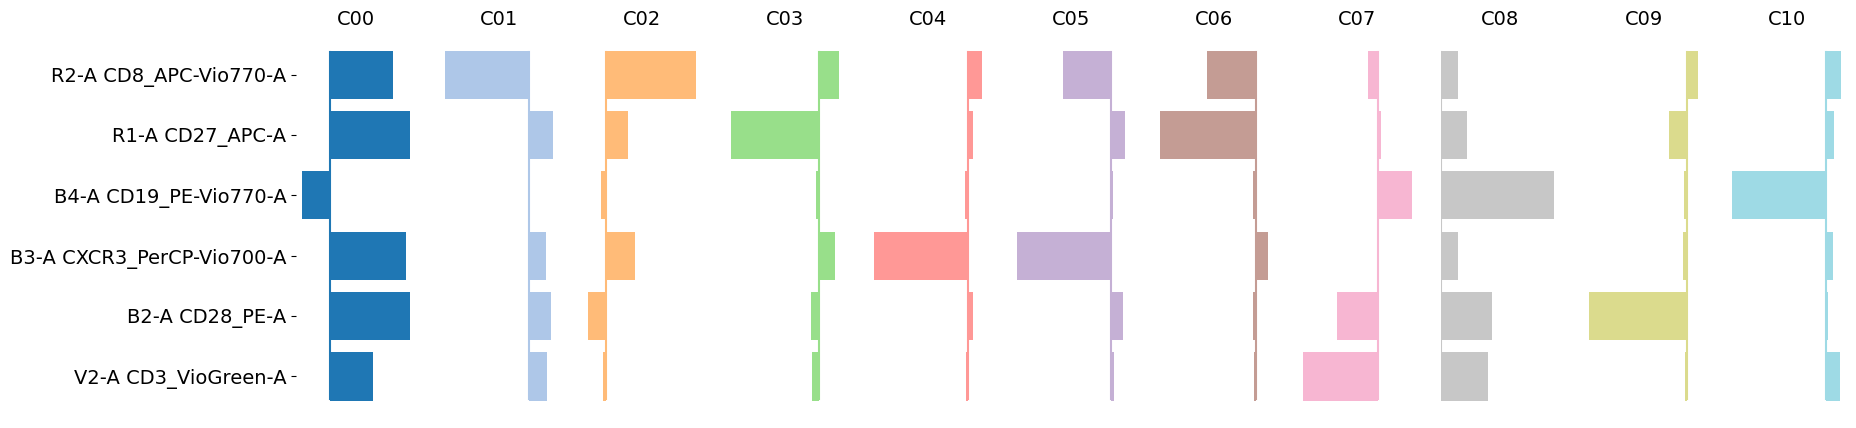

In [27]:
# Define colormap and number of clusters
tab20 = plt.colormaps['tab20']
n, p = leiden_clusters.shape

# Set up a grid of subplots based on the number of clusters
fig, axes = plt.subplots(1, n, figsize=(20, 5))

# Loop through clusters and plot the bar graphs
for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    # Label y-ticks for the first subplot
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [28]:
embedder = pacmap.PaCMAP()

In [29]:
X2 = embedder.fit_transform(X_scaled)

In [30]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

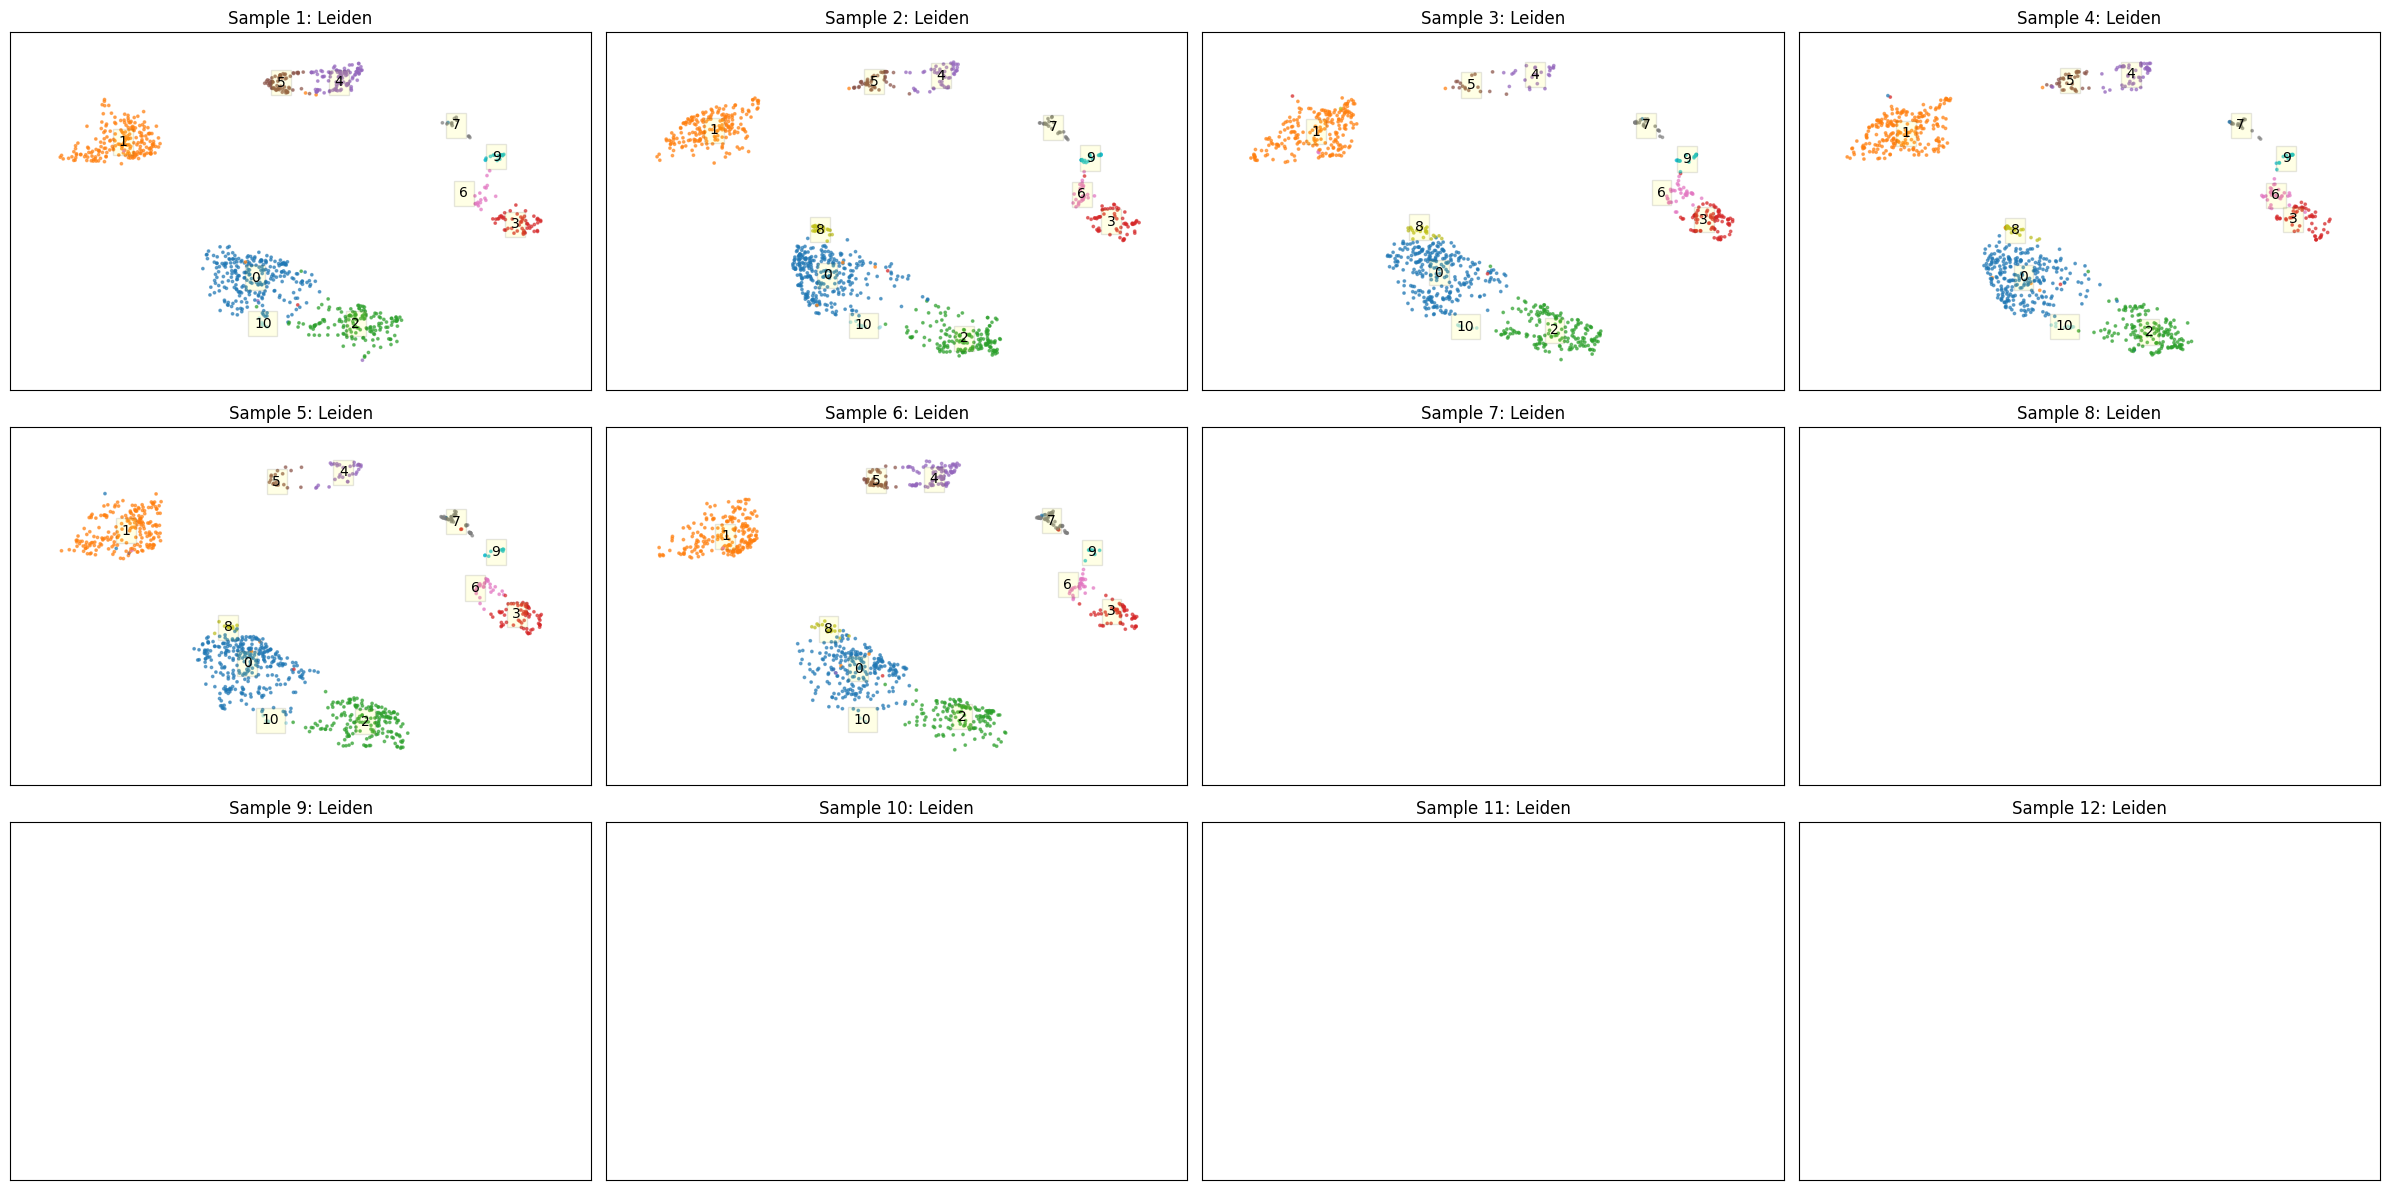

In [31]:
# Create a 2x4 grid for the subplots
fig, axes = plt.subplots(3, 4, figsize=(24, 12))  # Adjust figsize to make the plots bigger

# Loop through the clusters and plot the scatter plots
for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(12):  # Create 8 subplots in total (2x4 grid)
        # Select the community (cluster labels) corresponding to this sample
        z = community[j * k: (j + 1) * k]  # Ensure z is the same length as x and y

        # Select the x and y coordinates corresponding to this sample
        x = X2[j * k: (j + 1) * k, 0]  # X-axis for sample j
        y = X2[j * k: (j + 1) * k, 1]  # Y-axis for sample j
        
        # Assign correct subplot
        ax = axes[j // 4, j % 4]  # Convert index to 2x4 grid
        
        # Plot the data
        scatter = ax.scatter(x, y, s=3, c=z, cmap='tab20', alpha=0.6)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        
        # Set title for each subplot
        ax.set_title(f'Sample {j + 1}: {title}', fontsize=12)
        
        # Add text labels for clusters within the subplot
        for idx in np.unique(z):
            x_, y_ = x[z == idx], y[z == idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.1) # cluster number color, Lower alpha = lighter colors
            )

# Improve layout
plt.tight_layout()
plt.show()

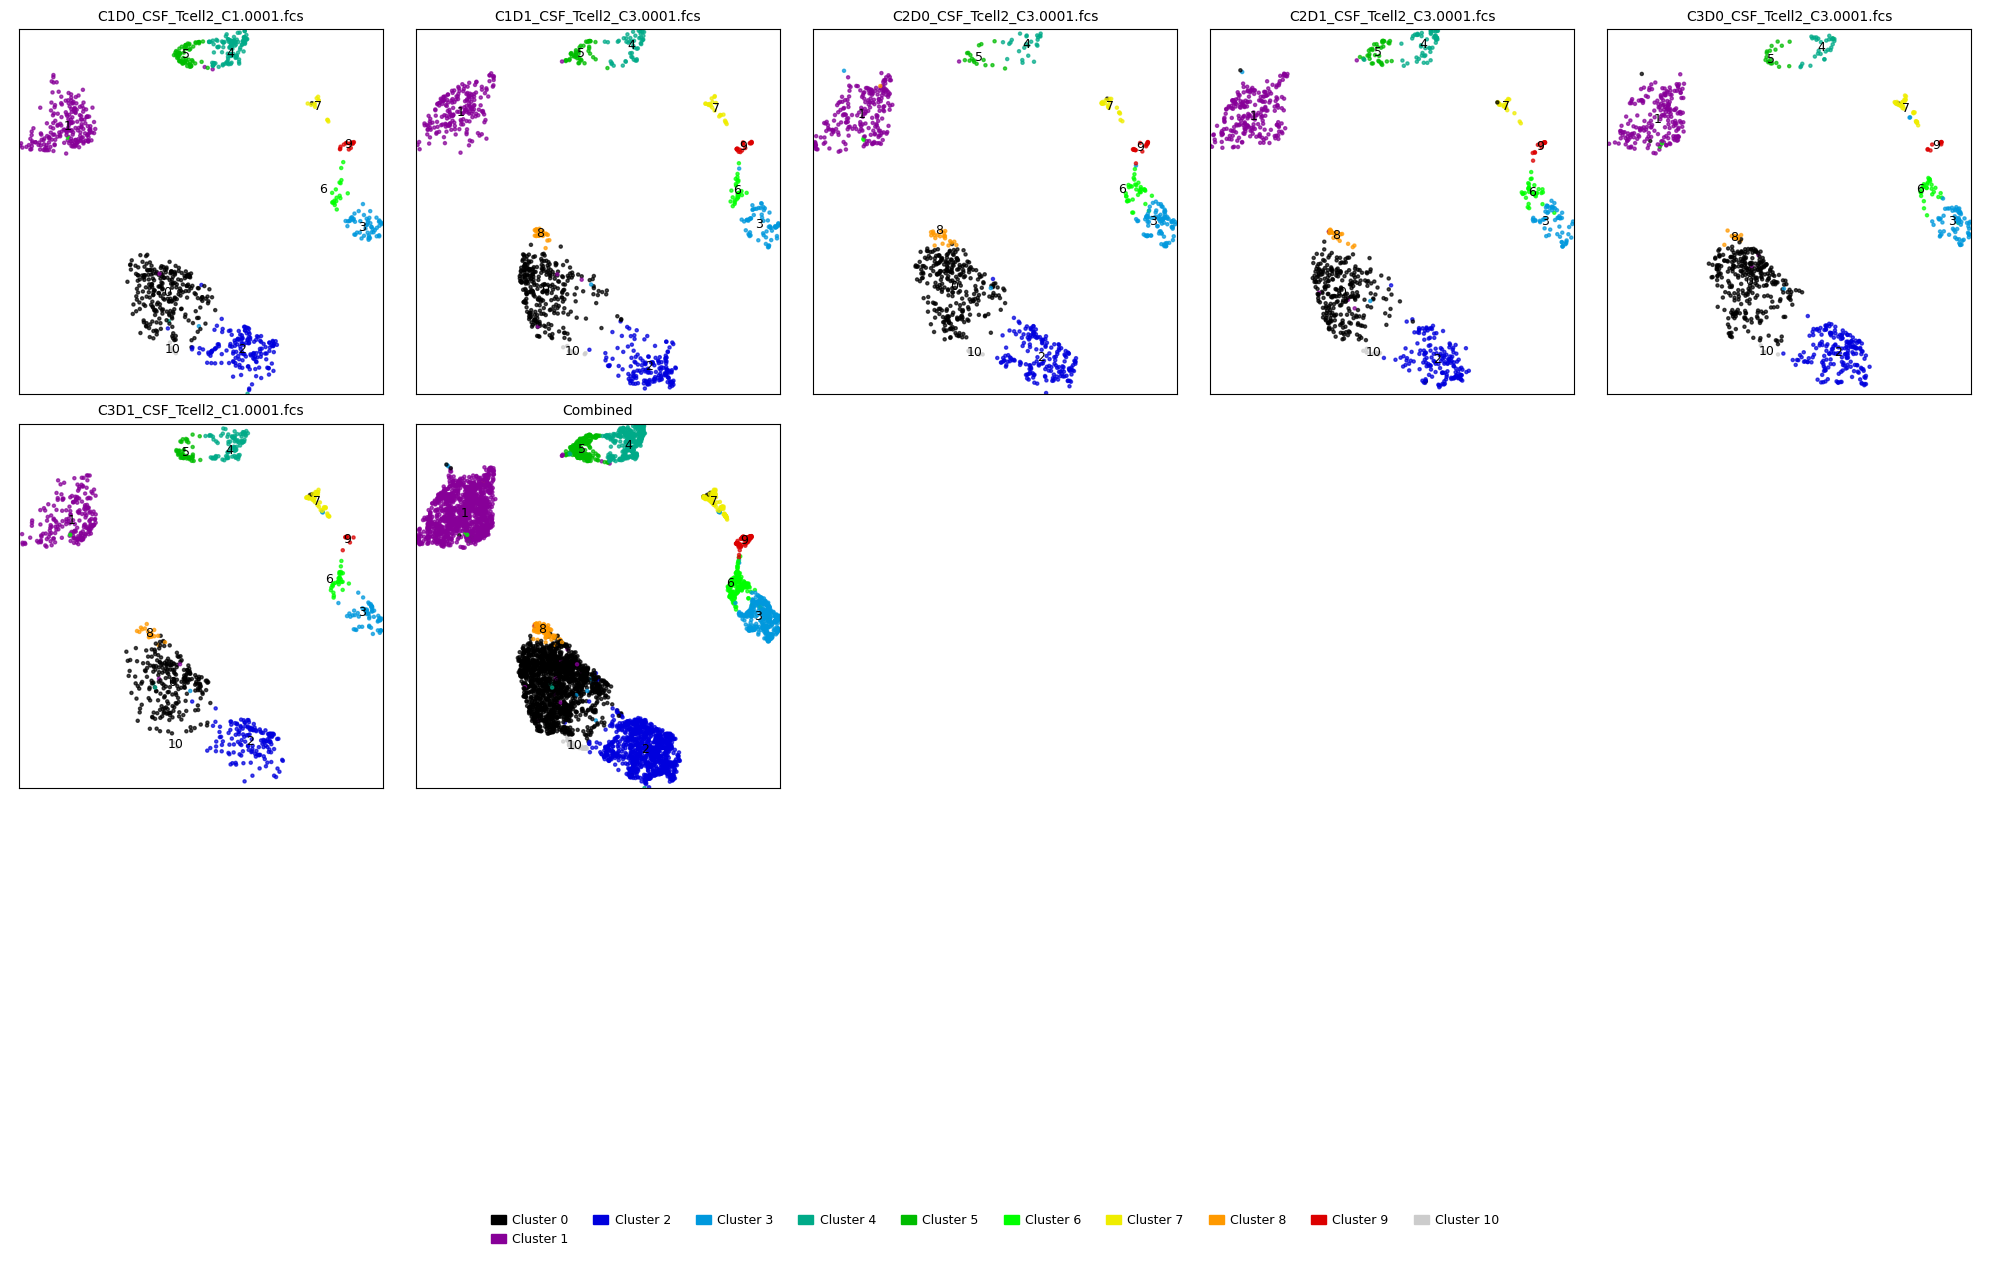

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# --- Setup ---
sample_ids  = workspace.get_sample_ids()
full_labels = np.asarray(communities[0])
n_samples   = len(sample_ids)
pts_per     = X2.shape[0] // n_samples

cmap = plt.get_cmap('nipy_spectral')
norm = mcolors.Normalize(vmin=full_labels.min(), vmax=full_labels.max())
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

# --- Plot ---
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

def plot_cluster(ax, x, y, z, title):
    ax.scatter(x, y, s=5, c=z, cmap=cmap, norm=norm, alpha=0.7) #s is dot size, smaller alpha more transparancy
    ax.set_title(title, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    for cl in np.unique(z):
        mask = (z == cl)
        ax.text(
            x[mask].mean(), y[mask].mean(),
            str(int(cl)), fontsize=9,
            color='black', ha='center', va='center',
            zorder=2
        )

# Plot individual samples
for i, sid in enumerate(sample_ids):
    start, end = i * pts_per, (i + 1) * pts_per
    plot_cluster(axes[i], X2[start:end, 0], X2[start:end, 1], full_labels[start:end], sid)

# Combined plot
plot_cluster(axes[len(sample_ids)], X2[:, 0], X2[:, 1], full_labels, 'Combined')

# Hide unused axes (if any)
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

# --- Add legend ---
unique_clusters = np.unique(full_labels)
handles = [
    mpatches.Patch(color=cmap(norm(cl)), label=f'Cluster {cl}')
    for cl in unique_clusters
]

plt.tight_layout()
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=min(len(handles), 10),
    frameon=False,
    fontsize=9,
    bbox_to_anchor=(0.5, -0.05),
    handlelength=1.2,
    handletextpad=0.5
)

plt.show()


# Marker expression ####


# V2-A CD3_VioGreen-A	B2-A CD39_PE-A	B3-A CD38_PerCP-Vio700-A	B4-A CD19_PE-Vio770-A	R1-A CD27_APC-A

In [33]:
# Reuse the existing PaCMAP layout and clustering output
sample_ids  = workspace.get_sample_ids()
full_labels = np.asarray(communities[0])
n_samples   = len(sample_ids)
pts_per     = X2.shape[0] // n_samples

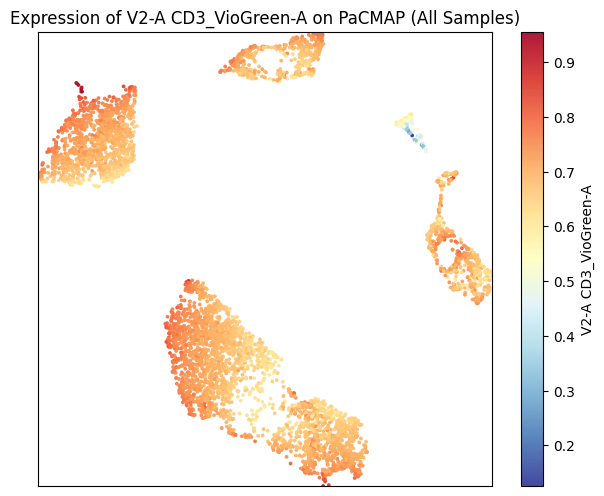

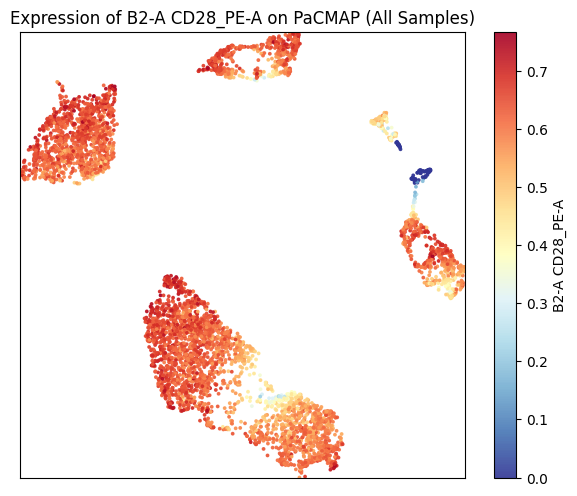

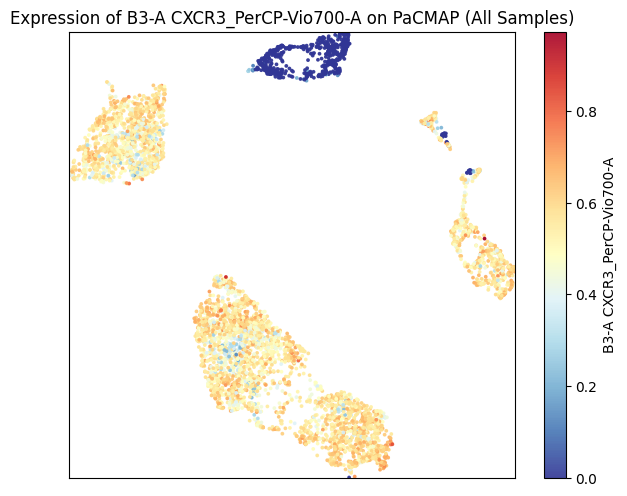

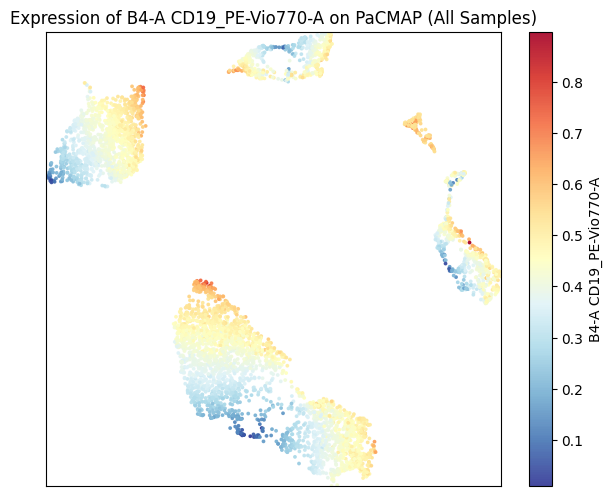

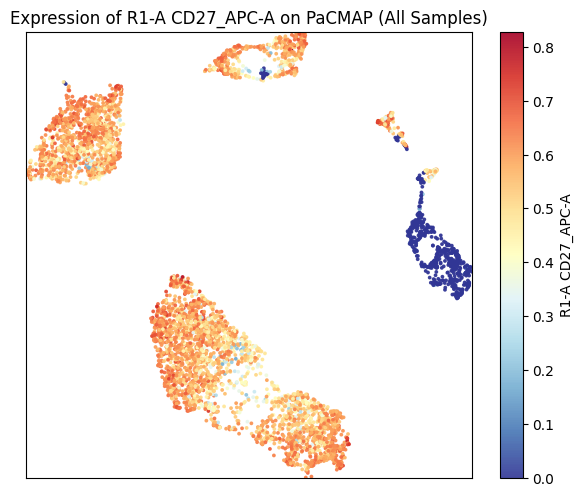

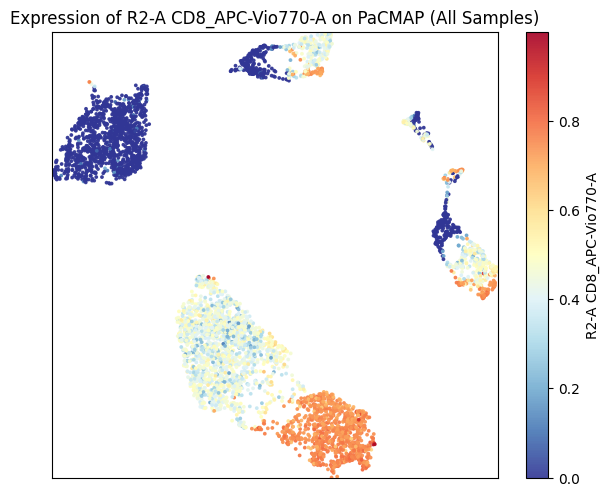

In [34]:
# Loop through each filtered marker

# Vivid diverging colormap: Red = high, Yellow = mid, Blue = low
cmap_expr = plt.get_cmap('RdYlBu_r')

for marker in X_filtered.columns:
    expr = X_filtered[marker].values

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        X2[:, 0], X2[:, 1],
        c=expr,
        cmap=cmap_expr,
        s=3,
        alpha=0.9
    )
    plt.colorbar(sc, label=marker)
    plt.title(f'Expression of {marker} on PaCMAP (All Samples)', fontsize=12)
    plt.xticks([]); plt.yticks([])
    plt.gca().set_aspect('equal', 'box')
    plt.xlim(X2[:,0].min(), X2[:,0].max())
    plt.ylim(X2[:,1].min(), X2[:,1].max())
    plt.tight_layout()
    plt.show()


## V2-A CD3_VioGreen-A	B2-A CD28_PE-A	B3-A CXCR3_PerCP-Vio700-A	B4-A CD19_PE-Vio770-A	R1-A CD27_APC-A	R2-A CD8_APC-Vio770-A

In [35]:
marker = 'V2-A CD3_VioGreen-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

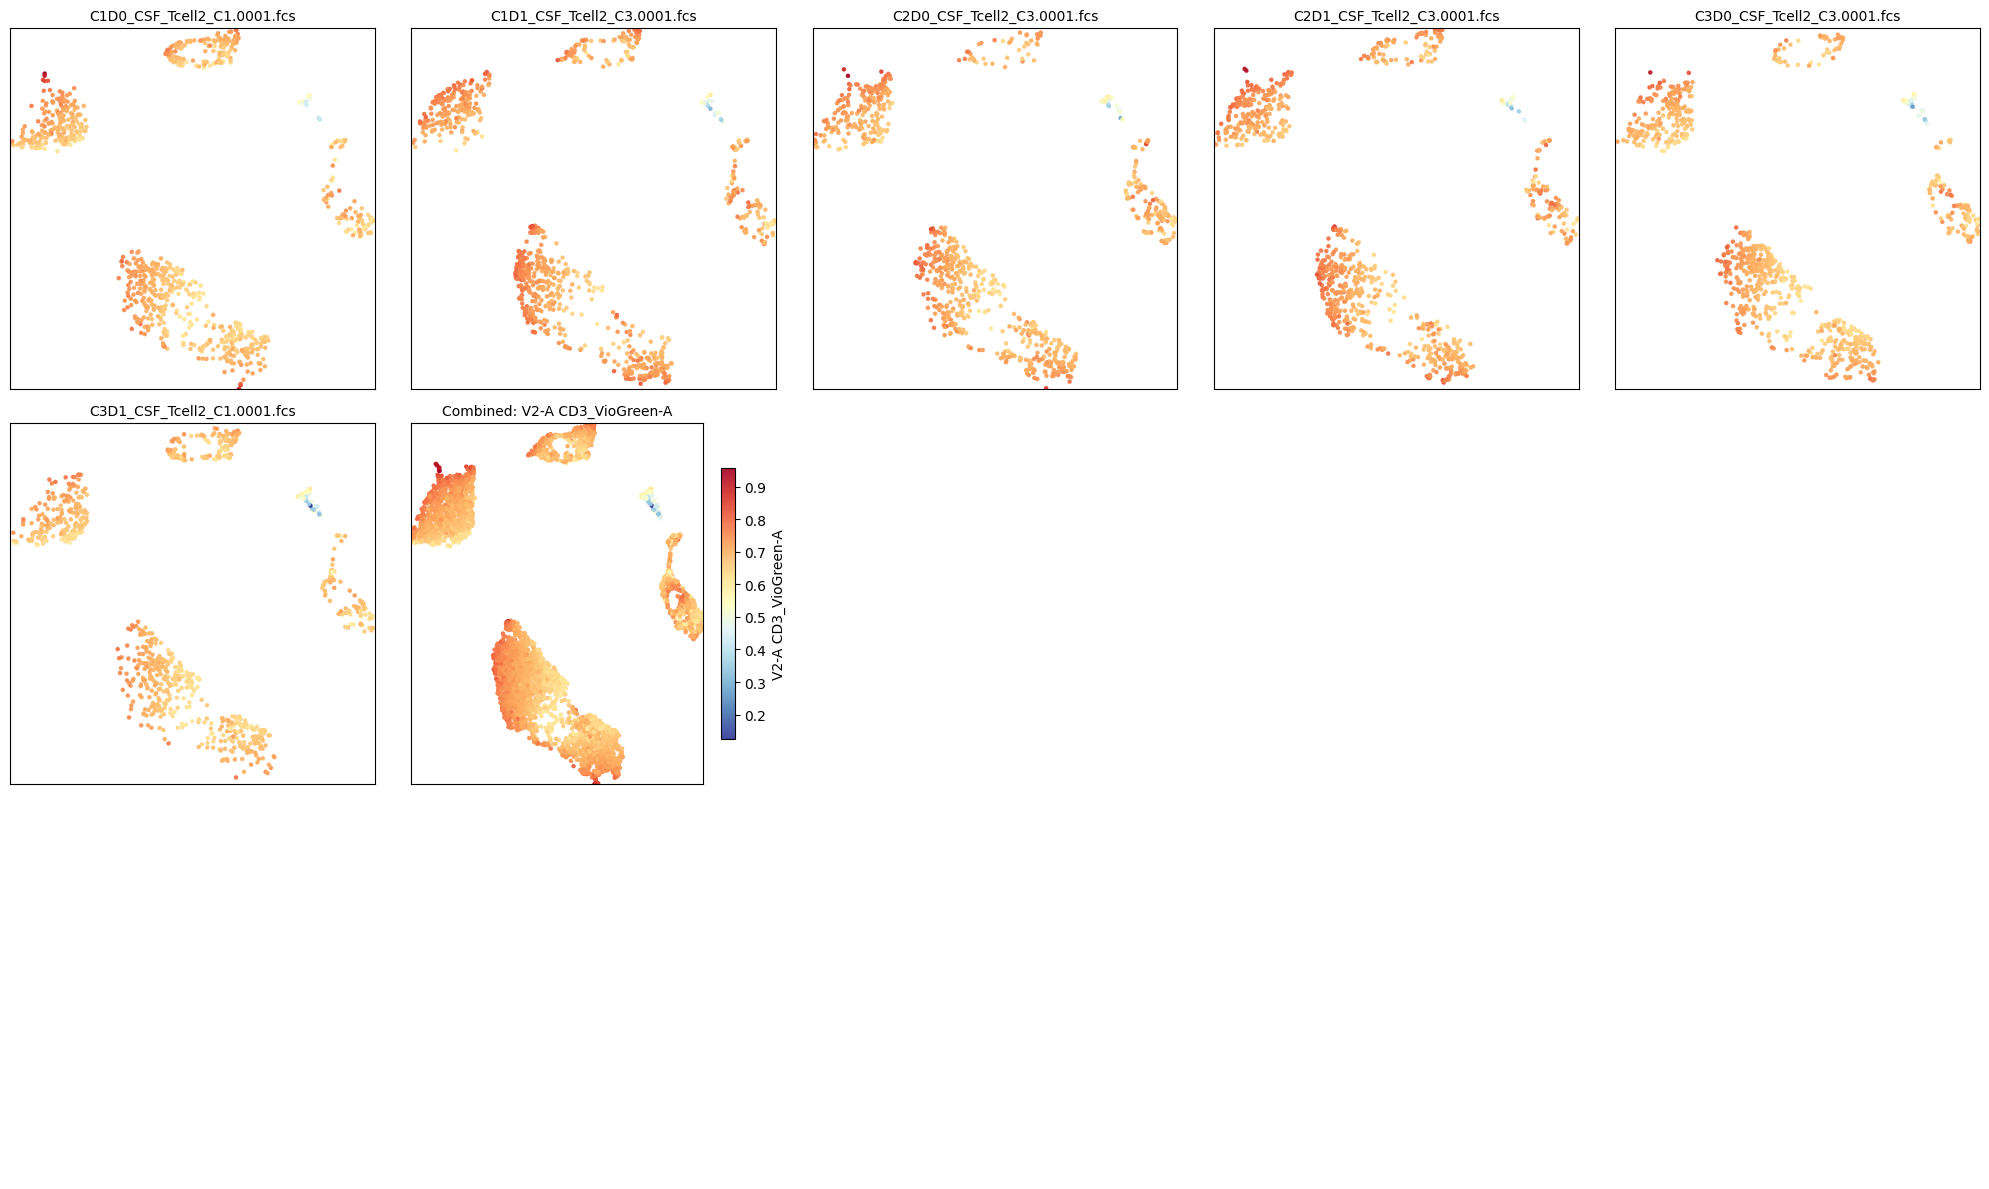

In [36]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [37]:
marker = 'B2-A CD28_PE-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

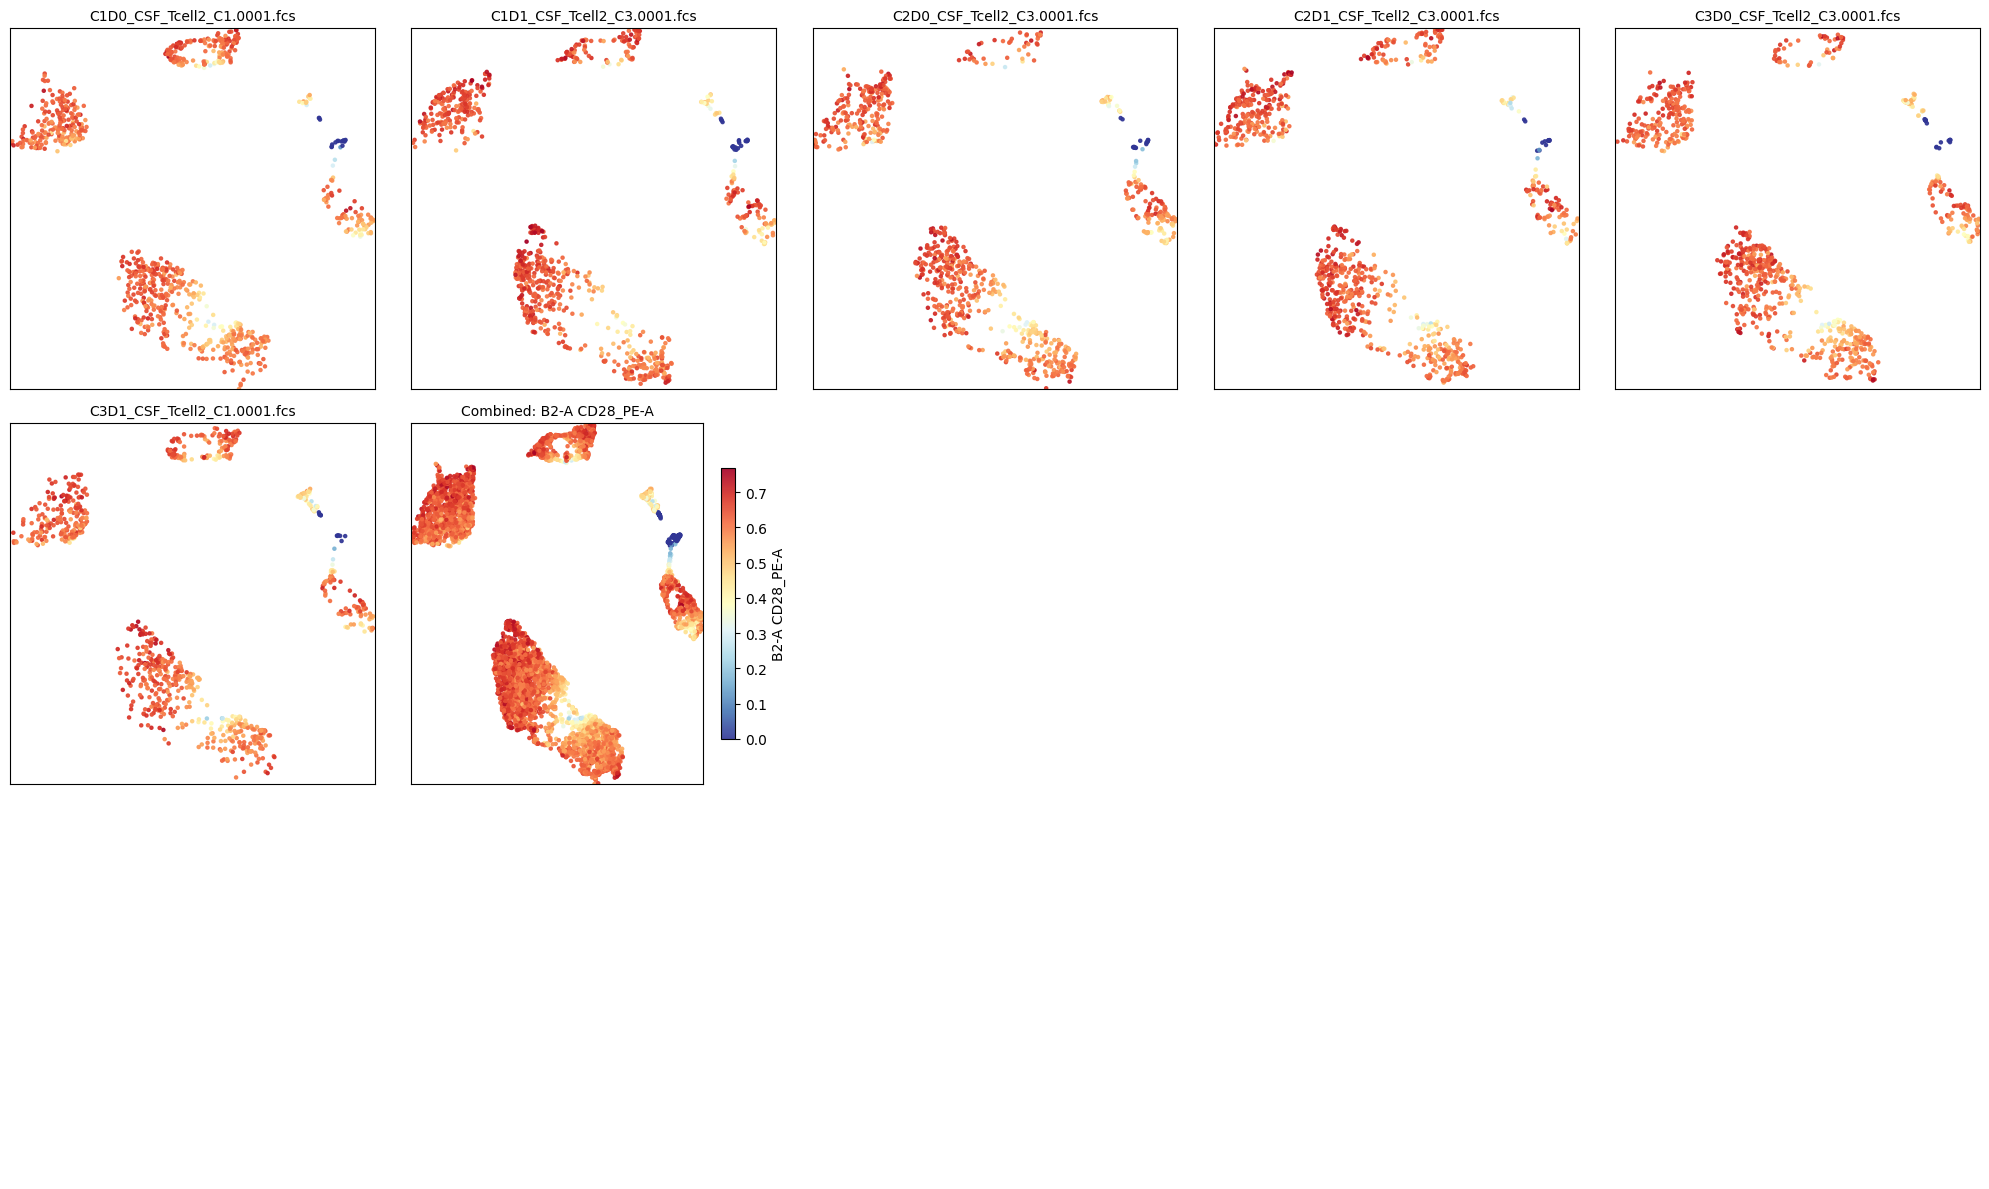

In [38]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [40]:
#V2-A CD3_VioGreen-A B2-A CD28_PE-A B3-A CXCR3_PerCP-Vio700-A B4-A CD19_PE-Vio770-A R1-A CD27_APC-A R2-A CD8_APC-Vio770-A
marker = 'B3-A CXCR3_PerCP-Vio700-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

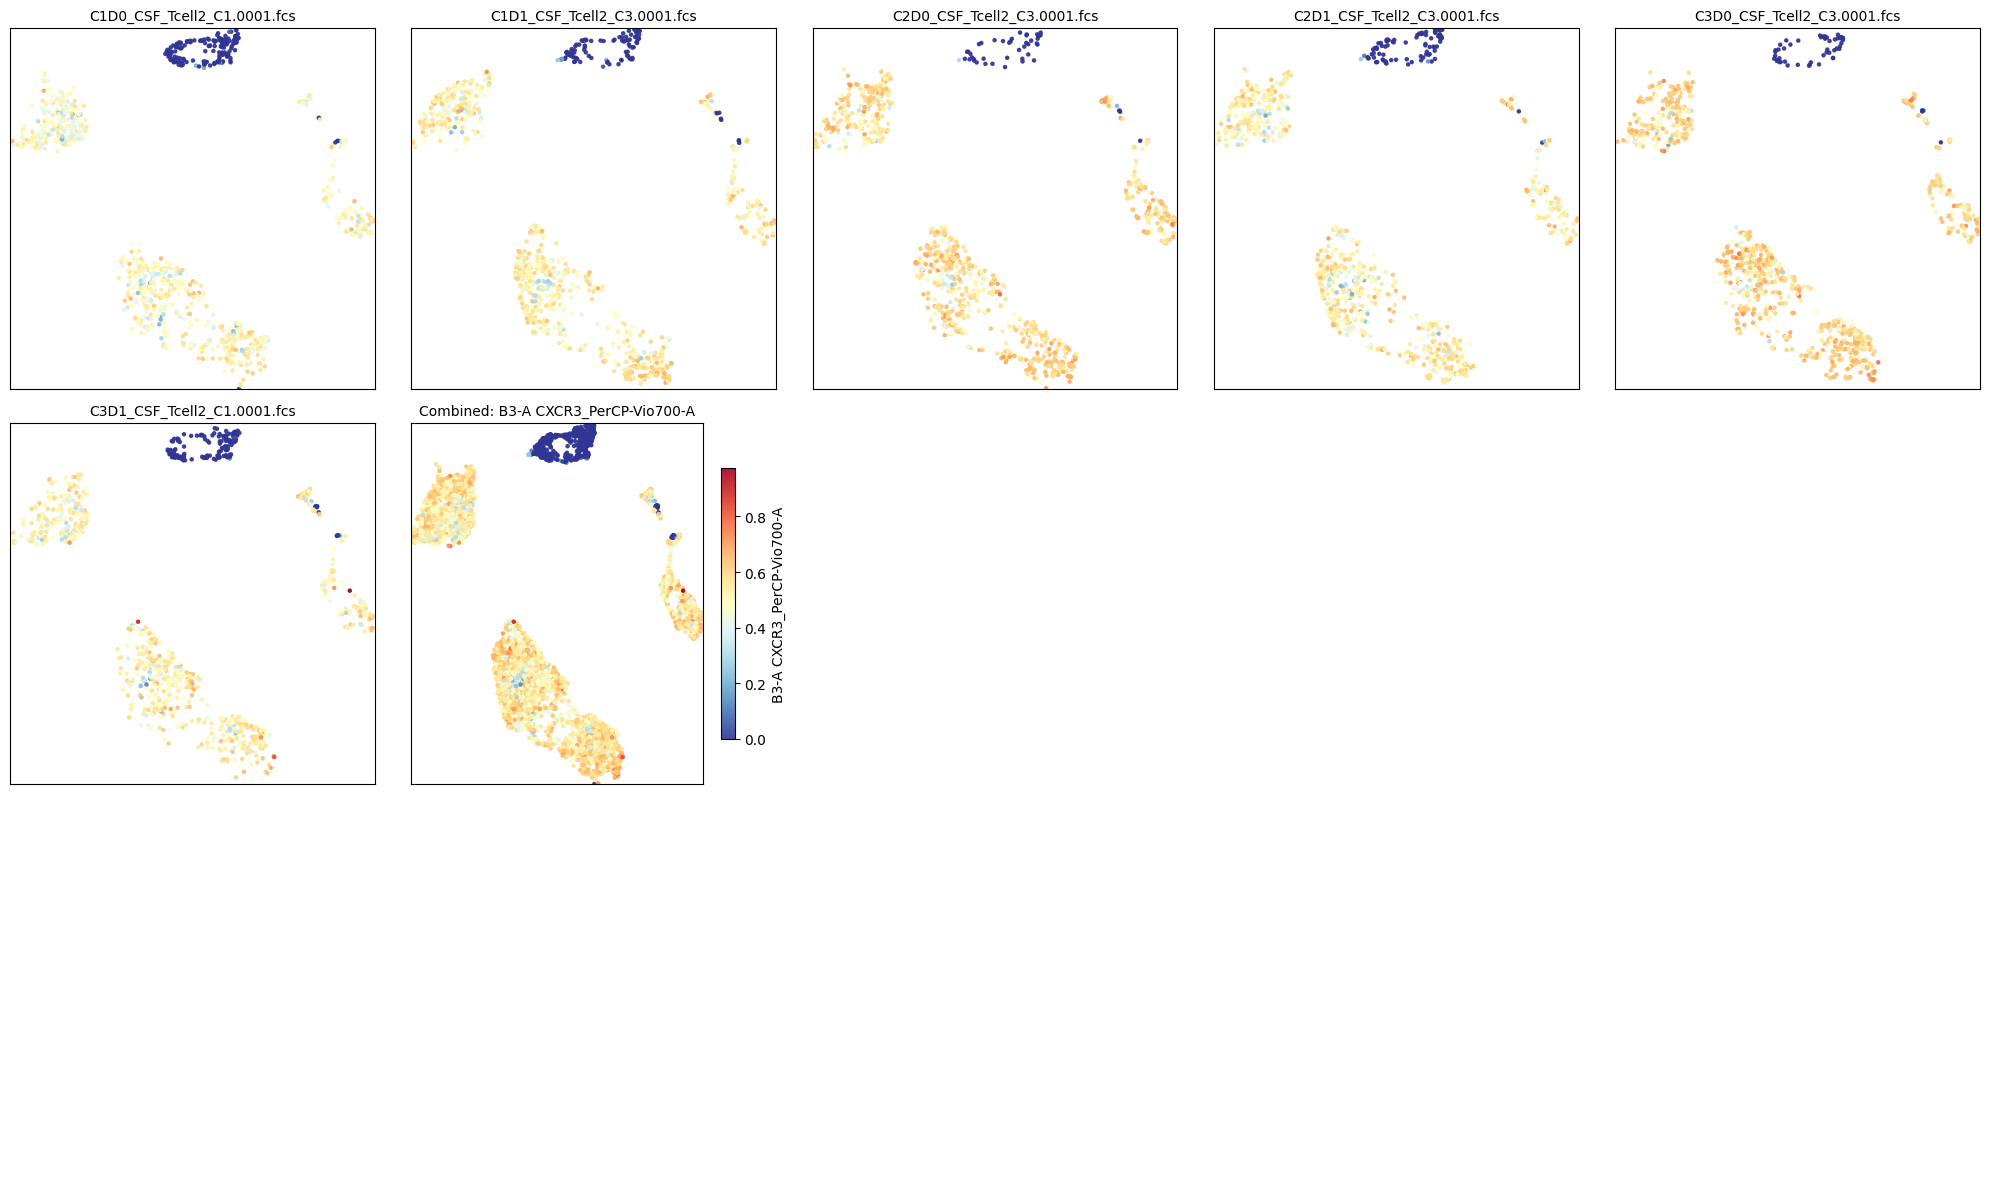

In [41]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [42]:
#B4-A CD19_PE-Vio770-A R1-A CD27_APC-A R2-A CD8_APC-Vio770-A
marker = 'B4-A CD19_PE-Vio770-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

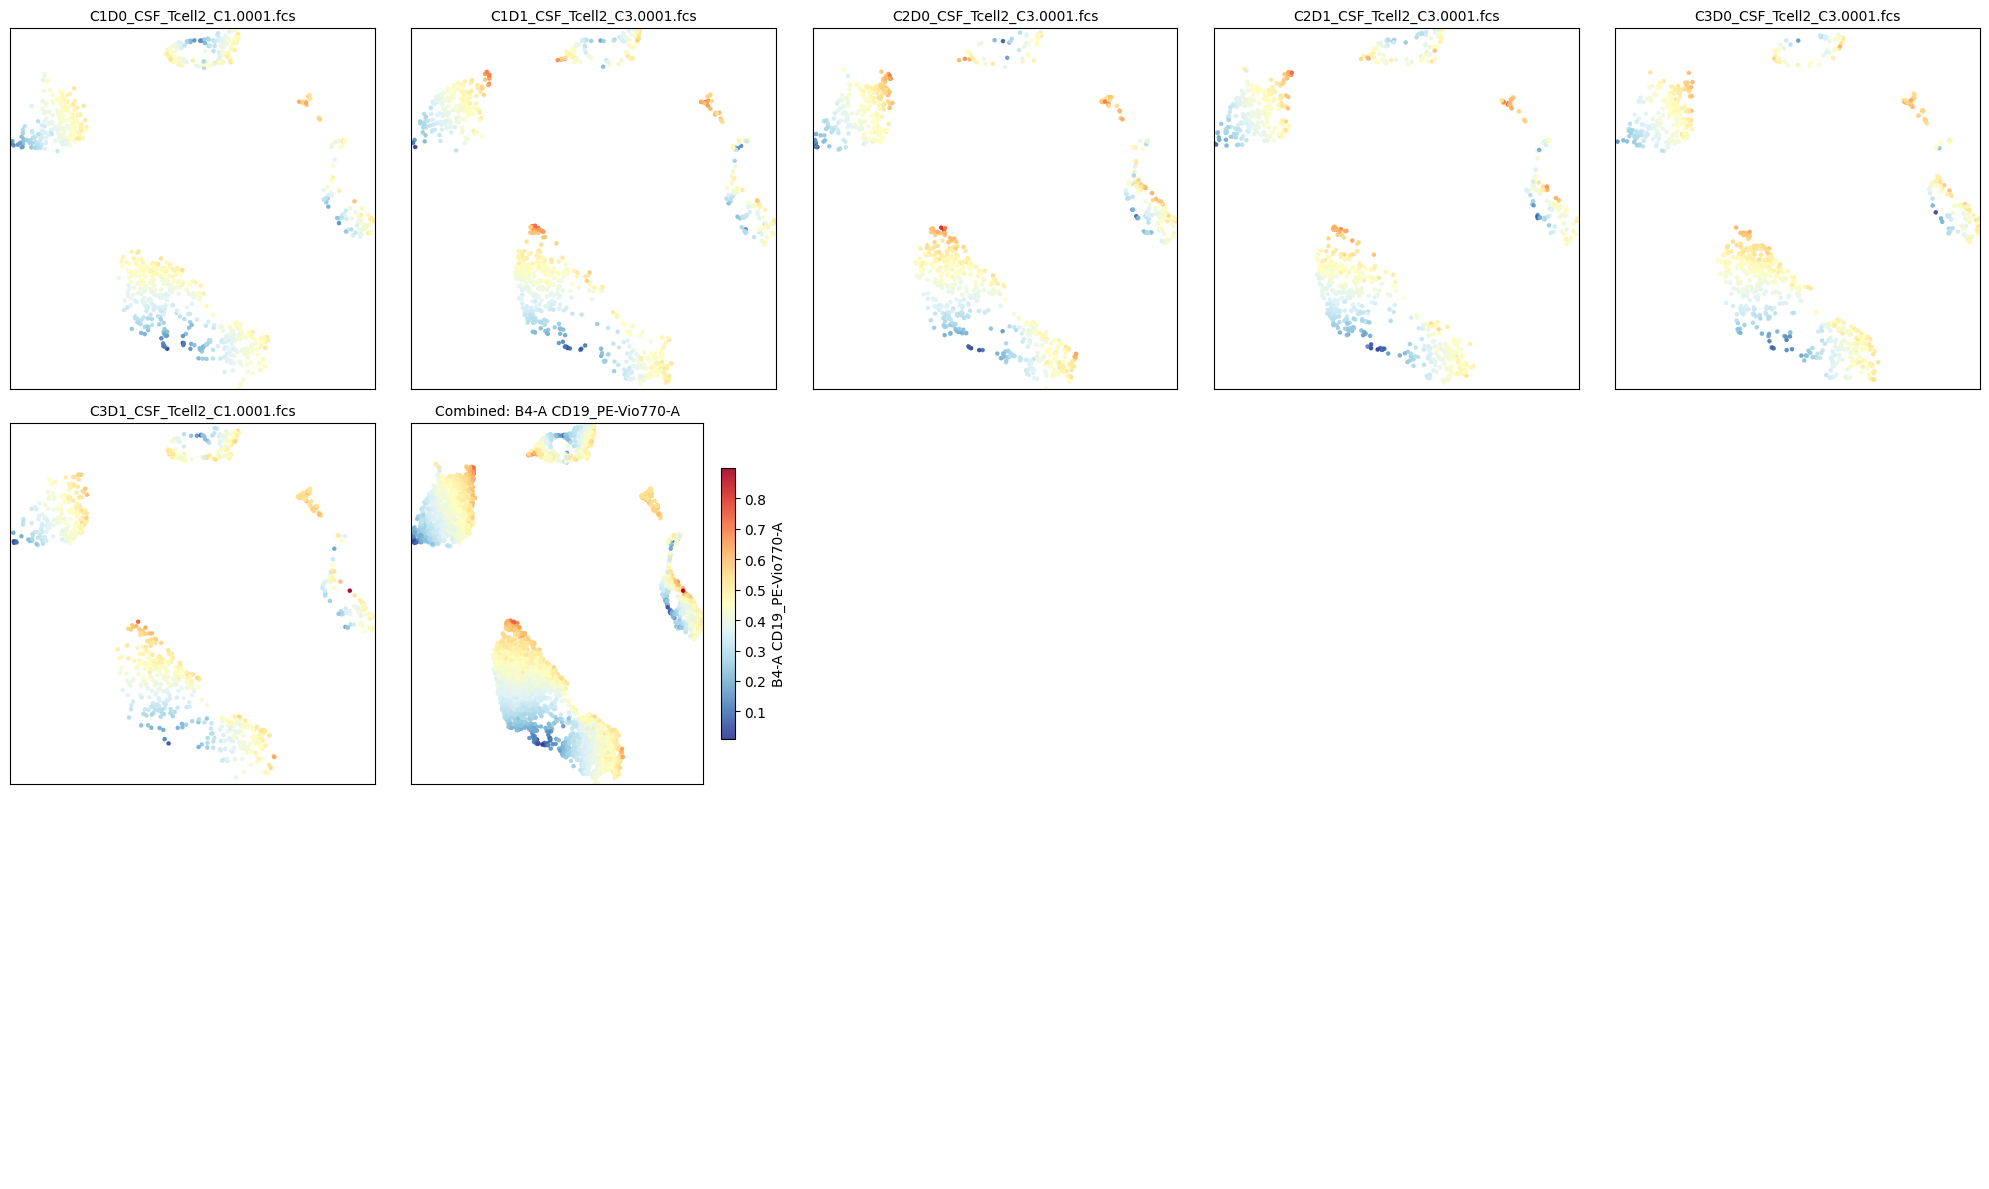

In [43]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [44]:
# B4-A CD19_PE-Vio770-A R1-A CD27_APC-A R2-A CD8_APC-Vio770-A
marker = 'R1-A CD27_APC-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

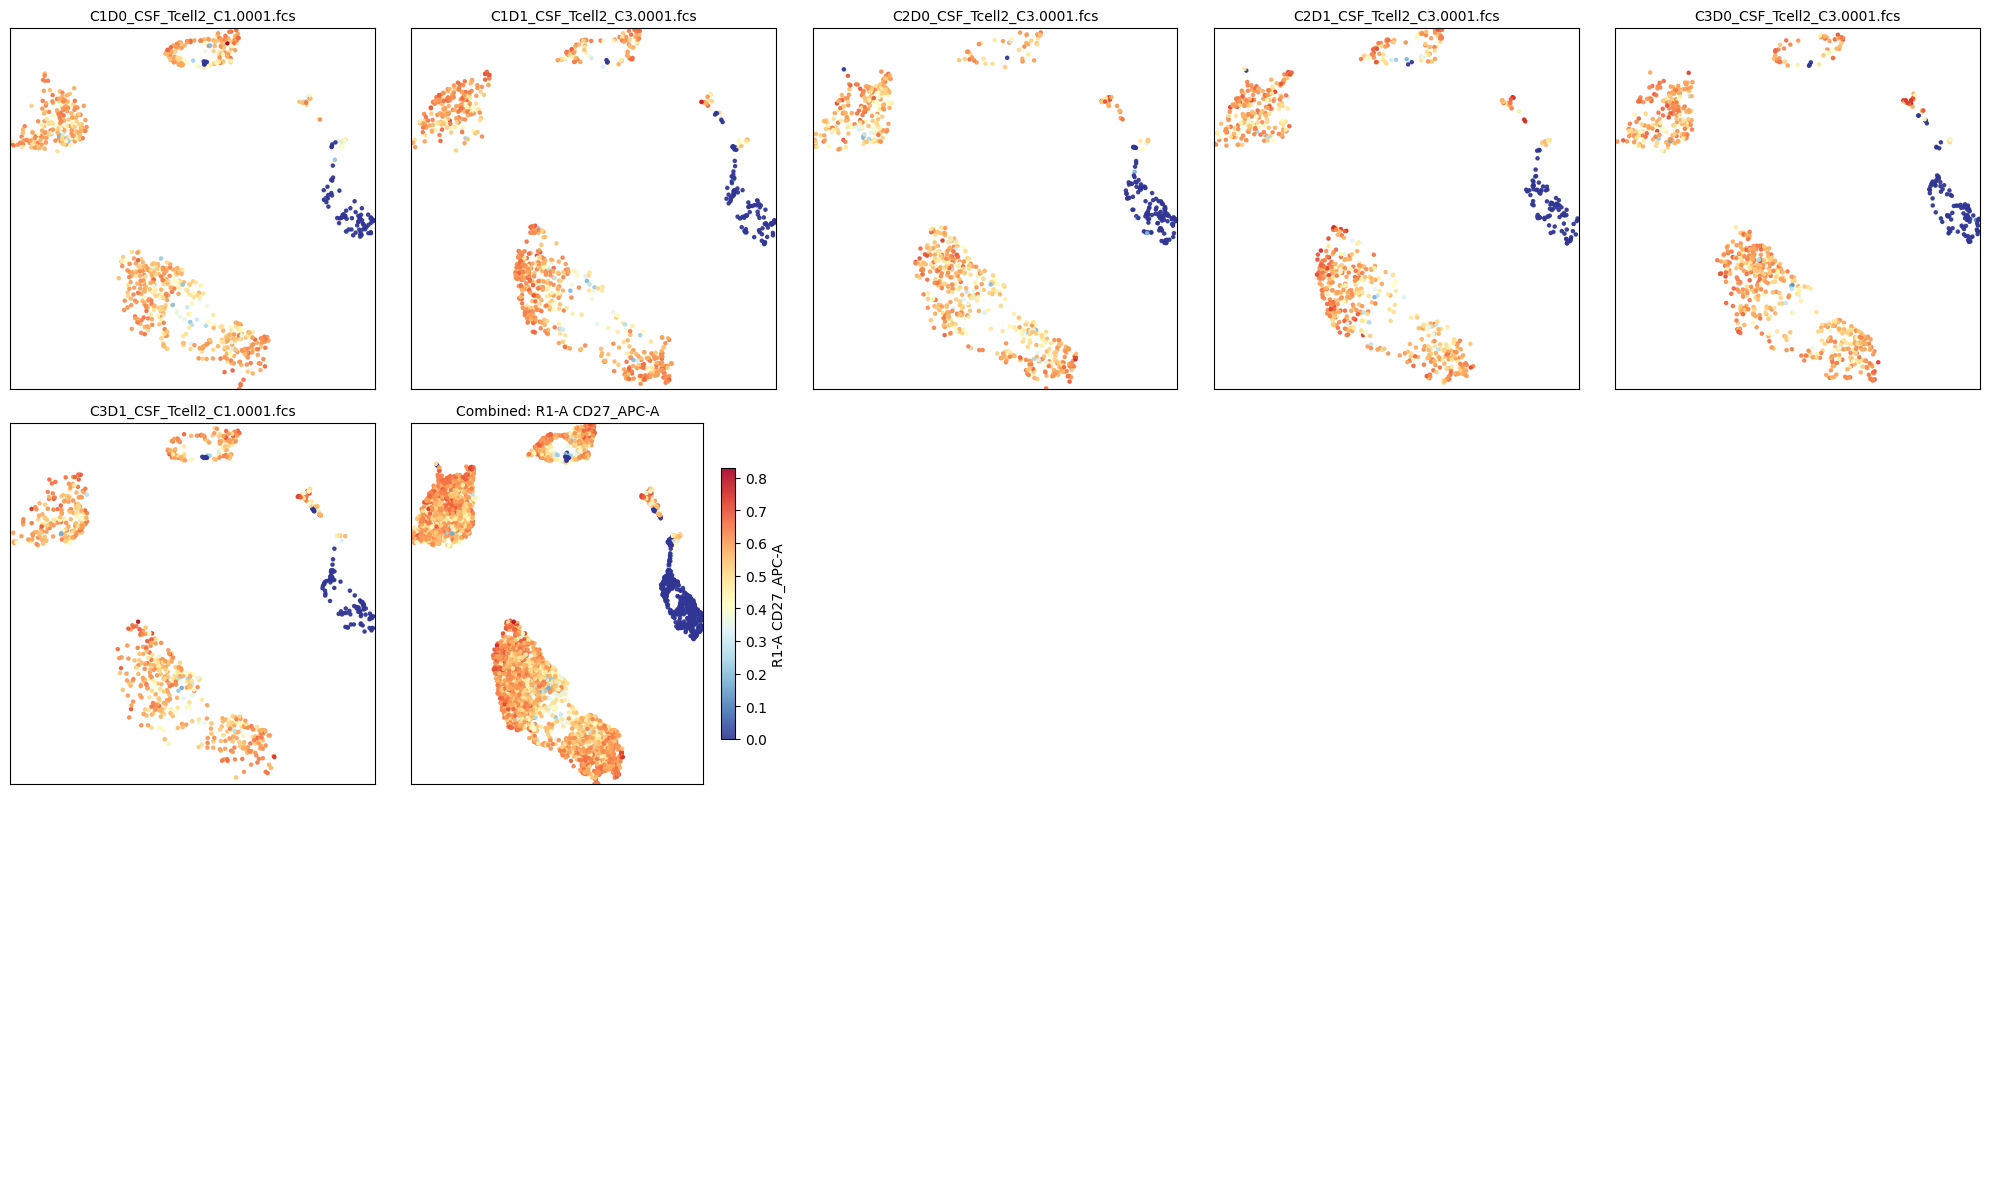

In [45]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [46]:
#B4-A CD19_PE-Vio770-A R1-A CD27_APC-A R2-A CD8_APC-Vio770-A
marker = 'R2-A CD8_APC-Vio770-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

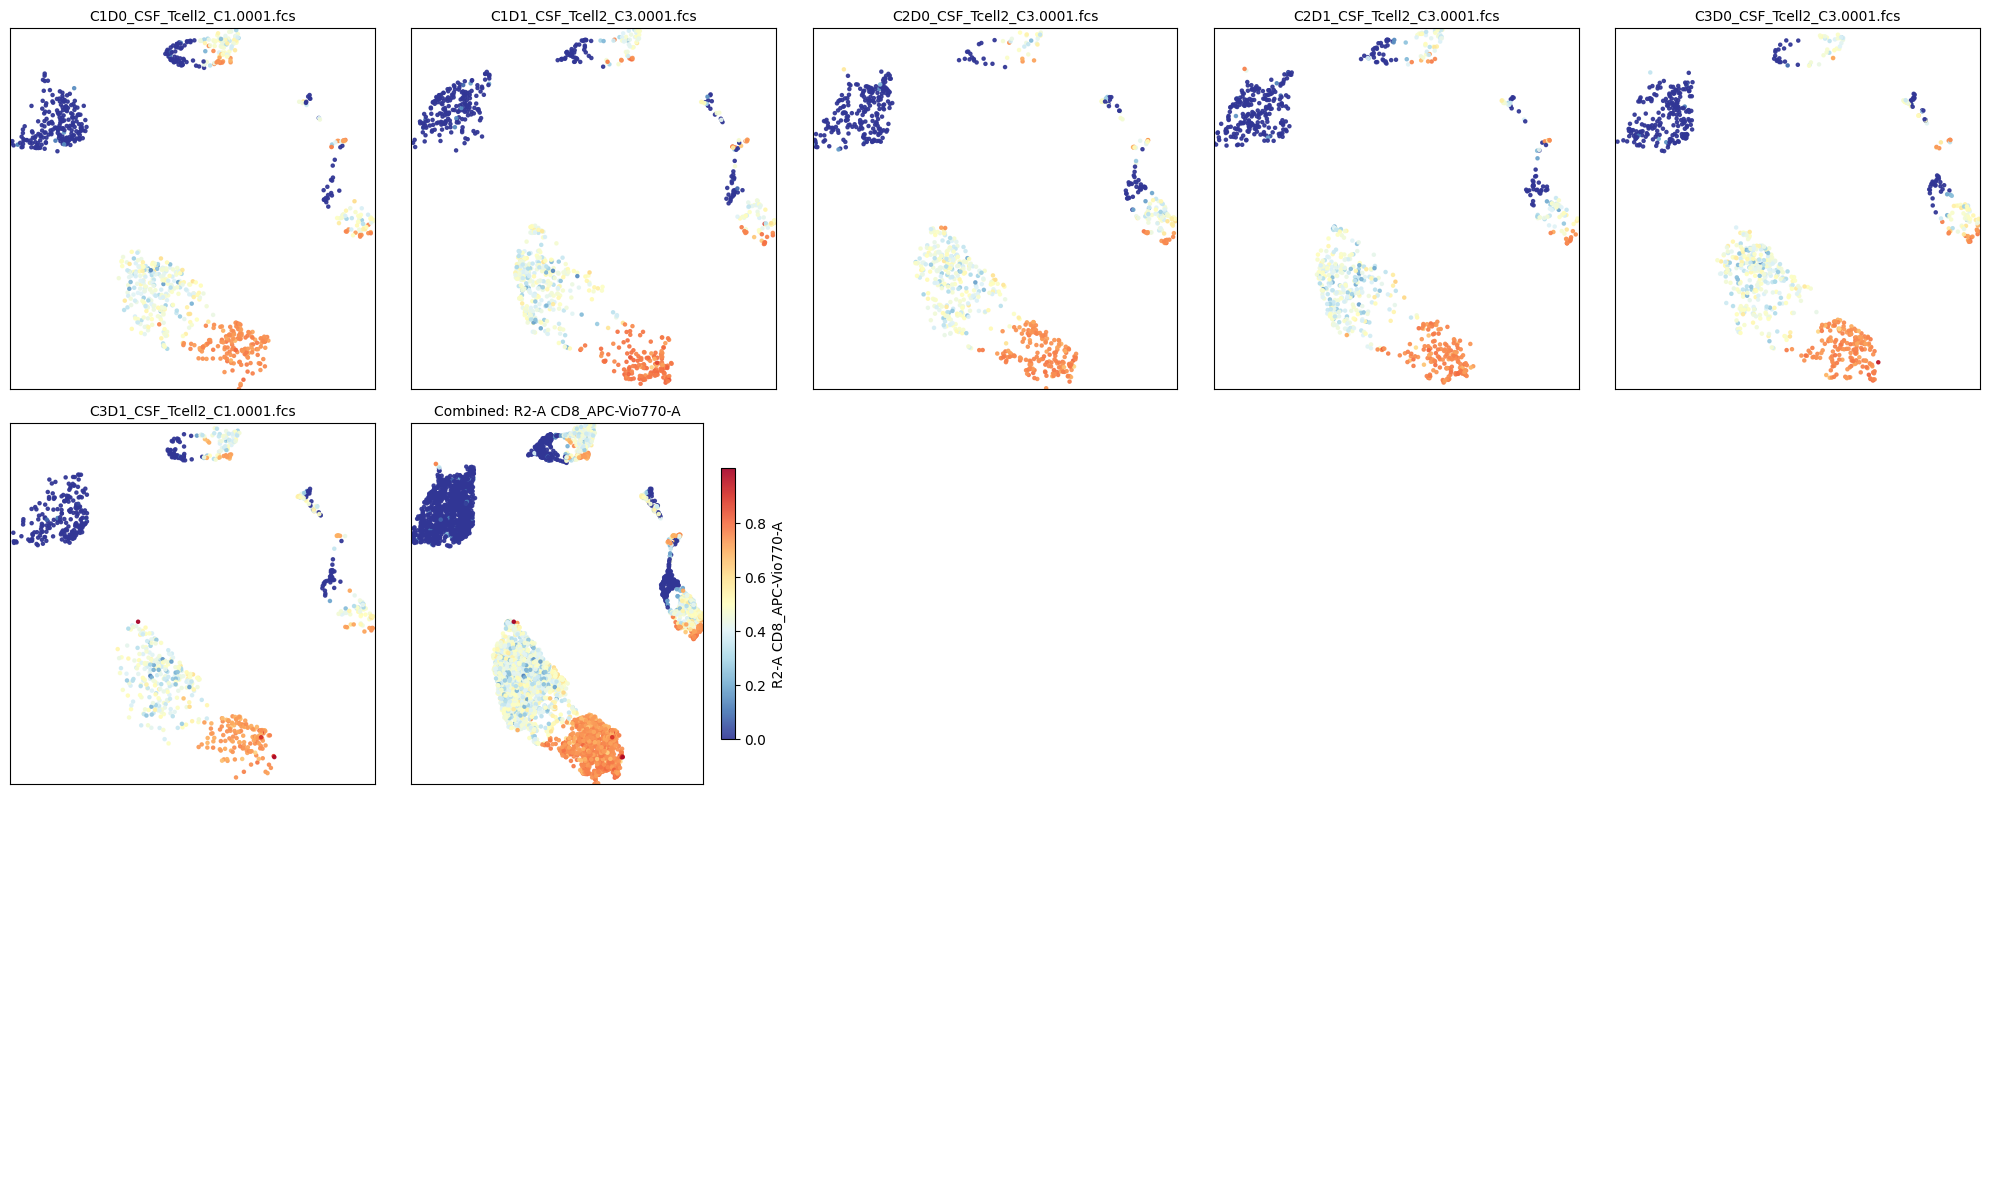

In [47]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
marker = 'B1-A CD47_FITC-A'  # Change this to any marker in your dataset
expr = X_filtered[marker].values

# Set consistent color scale
vmin, vmax = np.min(expr), np.max(expr)
cmap_expr = plt.get_cmap('RdYlBu_r')

# Define PaCMAP boundaries
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()

In [ ]:
# Create 3x5 grid for 12 samples + 1 combined plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each individual sample
for i, sid in enumerate(sample_ids):
    ax = axes[i]
    start, end = i * pts_per, (i + 1) * pts_per
    x, y, z = X2[start:end, 0], X2[start:end, 1], expr[start:end]

    sc = ax.scatter(x, y, s=5, c=z, cmap=cmap_expr, vmin=vmin, vmax=vmax, alpha=0.9)
    ax.set_title(sid, fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([]); ax.set_yticks([])

# Combined plot in next subplot
ax_comb = axes[len(sample_ids)]
points = ax_comb.scatter(
    X2[:, 0], X2[:, 1],
    s=5, c=expr,
    cmap=cmap_expr, vmin=vmin, vmax=vmax,
    alpha=0.9
)
ax_comb.set_title(f'Combined: {marker}', fontsize=10)
ax_comb.set_xlim(x_min, x_max)
ax_comb.set_ylim(y_min, y_max)
ax_comb.set_xticks([]); ax_comb.set_yticks([])

# Colorbar for expression
cbar = fig.colorbar(points, ax=ax_comb, orientation='vertical', shrink=0.75)
cbar.set_label(marker, fontsize=10)

# Turn off any unused subplot axes
for j in range(len(sample_ids) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [48]:
# Assuming 'communities_leiden' is a list or array of cluster assignments
# Create a DataFrame to hold the clusters
data = pd.DataFrame({
    'Cluster': communities_leiden
})


In [49]:
# Manually define the labels for each cluster
cluster_labels = {

    0/10: "CD3+CD8+CD27+CD28+CXCR3+ (CD8T)",
    1: "CD3+CD8-CD27+CD28+CXCR3+ (CD4T)",
    2: "CD3+CD8+CD27+CD28+/-CXCR3+ (CD8T)",
    3: "CD8+CD27-CXCR3+ (CD8T)",
    4: "CD3+CD8+CD27+CD28+CXCR3- (CD8T)",
    5: "CD3+CD8-CD27+CD28+CXCR3- (CD4T)",
    6: "CD3+CD8-CD27-CD28+CXCR3+ (CD4T)",
    7: "CD19+CD3-CD8-CD28-CD27+ (B cell)", 
    8: "CD19+CD3+CD27+CD28+CXCR3+ (CD4/8 CAR-T)",
    9: "pan-negative (CD3T)",




}

# Map the labels to the 'communities_leiden' array
labeled_clusters = pd.Series(communities_leiden).map(cluster_labels)

# Update the data with the labeled clusters
data['Labeled_Clusters'] = labeled_clusters

# Print the labeled clusters
print("Labeled Clusters:")
for cluster, label in cluster_labels.items():
    print(f"Cluster {cluster}: {label}")


Labeled Clusters:
Cluster 0.0: CD3+CD8+CD27+CD28+CXCR3+ (CD8T)
Cluster 1: CD3+CD8-CD27+CD28+CXCR3+ (CD4T)
Cluster 2: CD3+CD8+CD27+CD28+/-CXCR3+ (CD8T)
Cluster 3: CD8+CD27-CXCR3+ (CD8T)
Cluster 4: CD3+CD8+CD27+CD28+CXCR3- (CD8T)
Cluster 5: CD3+CD8-CD27+CD28+CXCR3- (CD4T)
Cluster 6: CD3+CD8-CD27-CD28+CXCR3+ (CD4T)
Cluster 7: CD19+CD3-CD8-CD28-CD27+ (B cell)
Cluster 8: CD19+CD3+CD27+CD28+CXCR3+ (CD4/8 CAR-T)
Cluster 9: pan-negative (CD3T)


In [50]:

print(f"Length of sample_ids: {len(sample_ids)}")
print(f"Length of communities_leiden: {len(communities_leiden)}")



Length of sample_ids: 6
Length of communities_leiden: 5400


## remember to match your cell number to previous subsample step 

In [51]:
# Assuming you have 8 samples and 10,000 cells per sample
samples = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample 6', 'Sample 7', 
'Sample 8', 'Sample 9', 'Sample 10', 'Sample 11', 'Sample 12', ]

n_samples = len(samples)
cells_per_sample = 900

# Initialize a dictionary to store the percentages
cluster_percentages = {}


In [52]:
# Loop through each sample using index ranges
for i, sample in enumerate(samples):
    
    # Get the range of indices for this sample
    start_idx = i * cells_per_sample
    end_idx = (i + 1) * cells_per_sample
    
    # Slice communities_leiden for this sample
    sample_clusters = communities_leiden[start_idx:end_idx]
    
    # Calculate the number of cells in each cluster for this sample
    cluster_counts = pd.Series(sample_clusters).value_counts()
    
    # Calculate the percentage of cells in each cluster
    cluster_percent = (cluster_counts / cells_per_sample) * 100
    
    # Store the percentages for this sample
    cluster_percentages[sample] = cluster_percent

In [53]:
# Convert the dictionary to a DataFrame for better visualization
percentages_df = pd.DataFrame(cluster_percentages).fillna(0)

# Display the percentage of cells in each cluster for each sample
print(percentages_df)


     Sample 1   Sample 2   Sample 3   Sample 4   Sample 5   Sample 6  \
0   27.888889  31.444444  30.777778  29.555556  33.666667  26.555556   
1   23.111111  22.222222  23.666667  26.000000  22.666667  22.888889   
2   17.333333  17.666667  19.444444  17.777778  20.444444  16.666667   
3    6.111111   6.888889  10.111111   6.444444   7.777778   6.777778   
4   12.666667   5.333333   2.777778   5.888889   3.222222  10.333333   
5    7.111111   4.888889   1.777778   3.777778   2.222222   5.111111   
6    2.111111   3.111111   4.222222   3.555556   3.333333   3.333333   
7    1.333333   2.444444   2.222222   2.111111   3.888889   5.333333   
8    0.000000   2.888889   2.555556   2.444444   1.222222   2.000000   
9    1.666667   2.111111   1.888889   1.444444   1.000000   0.777778   
10   0.666667   1.000000   0.555556   1.000000   0.555556   0.222222   

    Sample 7  Sample 8  Sample 9  Sample 10  Sample 11  Sample 12  
0        0.0       0.0       0.0        0.0        0.0        0.0  

In [ ]:
import matplotlib.pyplot as plt

# Choose the clusters you want to visualize (e.g., clusters 1, 3, 5)
clusters_to_visualize = [0, 1, 2, 3, 4, ]  # Change this to the clusters you're interested in

# Filter the percentages DataFrame to include only the selected clusters
filtered_percentages_df = percentages_df.loc[clusters_to_visualize]

# Loop through each sample and plot the percentage of cells in the selected clusters
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust grid based on number of samples
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot each sample's cluster percentages for the selected clusters
for i, sample in enumerate(filtered_percentages_df.columns):
    ax = axes[i]
    filtered_percentages_df[sample].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{sample}', fontsize=14)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Percentage (%)')
    ax.set_xticklabels(filtered_percentages_df.index, rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Choose the cluster you want to visualize (e.g., cluster 1)
cluster_to_visualize = 4  # Example: Change this to the cluster you're interested in

# Filter the percentages DataFrame to include only the selected cluster
filtered_percentages_df = percentages_df.loc[cluster_to_visualize]

# Plot the percentage of cells in the selected cluster across samples
plt.figure(figsize=(10, 6))
filtered_percentages_df.plot(kind='bar', color='skyblue')
plt.title(f'Percentage of Cells in Cluster {cluster_to_visualize} Across Samples', fontsize=16)
plt.xlabel('Sample')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Convert the dictionary to a DataFrame for better visualization
percentages_df = pd.DataFrame(cluster_percentages).fillna(0)

# Replace the index with the cluster labels
# Create a mapping for cluster numbers to labels
cluster_labels_df = pd.Series(cluster_labels)  # Convert the cluster_labels dict to a Series

# Replace the index (cluster numbers) with the corresponding cluster labels
percentages_df.index = percentages_df.index.map(cluster_labels_df)

# Display the percentage of cells in each cluster for each sample with labeled clusters
print(percentages_df)


In [ ]:
# Convert the dictionary to a DataFrame for better visualization
percentages_df = pd.DataFrame(cluster_percentages).fillna(0)

# Replace the index with the cluster labels
# Create a mapping for cluster numbers to labels
cluster_labels_df = pd.Series(cluster_labels)  # Convert the cluster_labels dict to a Series

# Replace the index (cluster numbers) with the corresponding cluster labels
percentages_df.index = percentages_df.index.map(cluster_labels_df)


# Display the percentage of cells in each cluster for each sample with labeled clusters
print(percentages_df_filtered)
